# Decision Tree
Haytham Mohamed

INFS 890 - Spring 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection, tree
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [2]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [3]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [4]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

front-end_cpu_use  orders_cpu_use  orders-db_cpu_use  user_cpu_use  \
0             0.0300          0.0100             0.0100        0.0100   
1             0.0600          0.0200             0.0200        0.0200   
2             0.0700          0.0300             0.0200        0.0300   
3             0.0700          0.0300             0.0200        0.0200   
4             0.0700          0.0200             0.0100        0.0200   

   user-db_cpu_use  shipping_cpu_use  payment_cpu_use  carts_cpu_use  \
0           0.0100            0.0100           0.0100         0.0300   
1           0.0200            0.0100           0.0100         0.1800   
2           0.0200            0.0100           0.0100         0.4400   
3           0.0200            0.0100           0.0100         0.2300   
4           0.0200            0.0100           0.0100         0.2400   

   carts-db_cpu_use  front-end_pods  orders_pods  user_pods  shipping_pods  \
0            0.0700          1.0000       1.0000     1.0000         1.0000   
1            0.1800          1.0000       1.0000     1.0000         1.0000   
2            0.2000          1.0000       1.0000     1.0000         1.0000   
3            0.1700          1.0000       1.0000     1.0000         1.0000   
4            0.1400          1.0000       1.0000     1.0000         1.0000   

   payment_pods  carts_pods  nodes_cpu_use  orders_req  orders_ltcy  
0        1.0000      1.0000         2.5000      0.1500       0.9311  
1        1.0000      1.0000         1.8900      0.1500       0.9311  
2        1.0000      1.0000         1.3500      0.1500       0.9311  
3        1.0000      1.0000         1.2600      0.1300       0.9311  
4        1.0000      1.0000         1.2800      0.3600       0.9311

In [5]:
data.shape

(3290, 18)

In [6]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 17 features


In [7]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [8]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


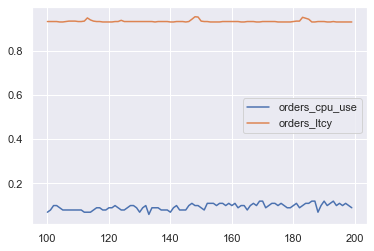

In [9]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [10]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

#sfm = PCA(random_state=180)

reg = tree.DecisionTreeRegressor() 

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'selector__estimator__max_depth' : [10, 15]
    , 'selector__estimator__n_estimators' : [20, 30, 40]
    # 'selector__n_components' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]   # with PCA
    , 'reg__min_samples_leaf': [1,2,3]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [11]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  2.3min finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                      

# Best Model

In [12]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0096:
Best CV params = {'reg__min_samples_leaf': 3, 'selector__estimator__max_depth': 15, 'selector__estimator__n_estimators': 40, 'selector__threshold': '0.6*mean'}


# Features Selected

In [13]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

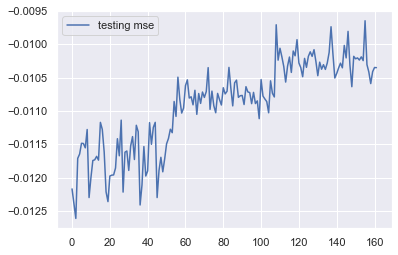

In [14]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [15]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.8998656810380787
Score (training) = -0.0019367599613352086


In [16]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.14 (0.13) 0.00 0.98 MSE


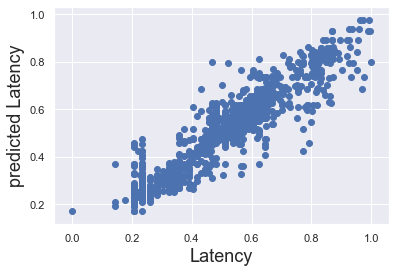

In [17]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

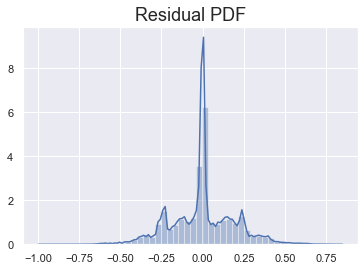

In [18]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [19]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

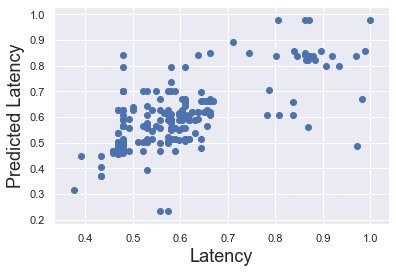

In [20]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

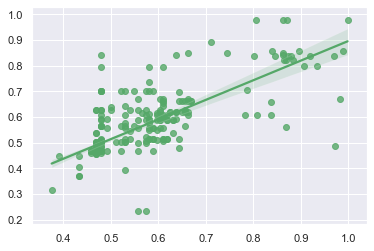

In [21]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [22]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

prediction  target
0      0.4727  0.4689
1      0.6379  0.5013
2      0.7004  0.5482
3      0.7004  0.5210
4      0.7004  0.4801

In [23]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0        0.4727  0.4689    0.0037       0.7948
1        0.6379  0.5013    0.1366      27.2606
2        0.7004  0.5482    0.1521      27.7508
3        0.7004  0.5210    0.1794      34.4350
4        0.7004  0.4801    0.2202      45.8717
..          ...     ...       ...          ...
324      0.3715  0.4325   -0.0610      14.1062
325      0.4489  0.3908    0.0581      14.8660
326      0.4489  0.4325    0.0164       3.7820
327      0.4049  0.4325   -0.0276       6.3760
328      0.3715  0.4325   -0.0610      14.1062

[329 rows x 4 columns]

In [24]:
perf.describe()

prediction   target  residual  difference%
count    329.0000 329.0000  329.0000     329.0000
mean       0.5493   0.5461    0.0032       7.6618
std        0.1214   0.1213    0.0834      11.7069
min        0.2346   0.3754   -0.4834       0.0000
25%        0.4689   0.4689   -0.0112       0.0321
50%        0.4878   0.4801    0.0000       2.4806
75%        0.6082   0.5961    0.0149      10.1318
max        0.9767   0.9980    0.3620      75.3945

In [25]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
164        0.47    0.47      0.00         0.00
37         0.47    0.47      0.00         0.00
41         0.47    0.47      0.00         0.00
42         0.47    0.47      0.00         0.00
43         0.47    0.47      0.00         0.00
49         0.47    0.47      0.00         0.00
50         0.47    0.47      0.00         0.00
51         0.47    0.47      0.00         0.00
52         0.47    0.47      0.00         0.00
151        0.47    0.47      0.00         0.00
132        0.47    0.47      0.00         0.00
68         0.47    0.47      0.00         0.00
69         0.47    0.47      0.00         0.00
71         0.47    0.47      0.00         0.00
72         0.47    0.47      0.00         0.00
73         0.47    0.47      0.00         0.00
75         0.47    0.47      0.00         0.00
76         0.47    0.47      0.00         0.00
78         0.47    0.47      0.00         0.00
79         0.47    0.47      0.00         0.00
82         0.47    0.47      0.00         0.00
83         0.47    0.47      0.00         0.00
127        0.47    0.47      0.00         0.00
124        0.47    0.47      0.00         0.00
123        0.47    0.47      0.00         0.00
98         0.47    0.47      0.00         0.00
99         0.47    0.47      0.00         0.00
103        0.47    0.47      0.00         0.00
104        0.47    0.47      0.00         0.00
108        0.47    0.47      0.00         0.00
155        0.47    0.47      0.00         0.00
157        0.47    0.47      0.00         0.00
53         0.47    0.47      0.00         0.00
207        0.47    0.47      0.00         0.00
185        0.47    0.47      0.00         0.00
184        0.47    0.47      0.00         0.00
183        0.47    0.47      0.00         0.00
25         0.47    0.47      0.00         0.00
195        0.47    0.47      0.00         0.00
161        0.47    0.47      0.00         0.00
218        0.47    0.47      0.00         0.00
182        0.47    0.47      0.00         0.00
189        0.47    0.47      0.00         0.00
28         0.47    0.47      0.00         0.00
15         0.47    0.47      0.00         0.00
14         0.47    0.47      0.00         0.00
13         0.47    0.47      0.00         0.00
179        0.47    0.47      0.00         0.00
12         0.47    0.47      0.00         0.00
11         0.47    0.47      0.00         0.00
259        0.47    0.47      0.00         0.00
181        0.47    0.47      0.00         0.00
97         0.47    0.47      0.00         0.00
111        0.47    0.47      0.00         0.00
80         0.47    0.47      0.00         0.00
70         0.47    0.47      0.00         0.00
81         0.47    0.47      0.00         0.00
100        0.47    0.47      0.00         0.00
102        0.47    0.47      0.00         0.00
101        0.47    0.47      0.00         0.00
129        0.47    0.47      0.00         0.00
130        0.47    0.47      0.00         0.00
128        0.47    0.47      0.00         0.00
126        0.47    0.47      0.00         0.00
131        0.47    0.47      0.00         0.00
95         0.47    0.47      0.00         0.00
154        0.47    0.47      0.00         0.00
133        0.47    0.47      0.00         0.00
110        0.47    0.47      0.00         0.00
135        0.47    0.47      0.00         0.00
136        0.47    0.47      0.00         0.00
137        0.47    0.47      0.00         0.00
122        0.47    0.47      0.00         0.00
54         0.47    0.47      0.00         0.00
46         0.47    0.47      0.00         0.00
45         0.47    0.47      0.00         0.00
44         0.47    0.47      0.00         0.00
40         0.47    0.47      0.00         0.00
39         0.47    0.47      0.00         0.00
38         0.47    0.47      0.00         0.00
47         0.47    0.47      0.00         0.00
84         0.47    0.47      0.00         0.00
160        0.47    0.47     -0.00         0.03
163        0.47    0.47     -0.00         0.03
64        

# *** Prediction Accuracy

In [26]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.5267971171377022


In [27]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.08330735454463456
